# **디스플레이 생산라인 센서데이터 분석 프로젝트
## 🚀데이터 전처리 소스코드
1. 결측치 처리
2. 분산이 0인 피처 제거 📌
3. 피처(독립변수) 간 종속성 높은 피처 제거 📌

In [ ]:
# 패키지 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
# 데이터 불러오기 - 결측치 처리된 데이터
# 첫번째 열을 인덱스로 사용함
fact_data = pd.read_csv("/content/drive/MyDrive/나무플래닛/3. 산출물/fact_data_nan", index_col=0)

In [ ]:
# 데이터 확인
fact_data.info()
fact_data.head()
# 데이터 타입은 float과 int형으로 모두 숫자 데이터

<class 'pandas.core.frame.DataFrame'>
Index: 8145 entries, 2016-01-01 07 to 2016-12-31 23
Columns: 833 entries, LIFT.OUT.ROL.MTR.M1.SPD.1WSI40101 to R.Vac
dtypes: float64(827), int64(6)
memory usage: 51.8+ MB


,LIFT.OUT.ROL.MTR.M1.SPD.1WSI40101,LIFT.OUT.ROL.MTR.M2.SPD.1WSI40102,LIFT.OUT.ROL.MTR.M3.SPD.1WSI40103,LEHR.DRV.MTR..M4.1.SPD.1WSI40104,LEHR.DRV.MTR..M4.2.SPD.1WSI40105,LEHR.DRV.MTR..M5.1.SPD.1WSI40106,LEHR.DRV.MTR..M5.2.SPD.1WSI40107,LEHR.DRV.MTR..M6.1.SPD.1WSI40108,LEHR.DRV.MTR..M6.2.SPD.1WSI40109,LEHR.DRV.MTR..M7.1.SPD.1WSI40110,LEHR.DRV.MTR..M7.2.SPD.1WSI40111,LEHR.DRV.MTR..M8.1.SPD.1WSI40112,LEHR.DRV.MTR..M8.2.SPD.1WSI40113,LEHR.DRV.MTR..M9.1.SPD.1WSI40114,LEHR.DRV.MTR..M9.2.SPD.1WSI40115,DRIVE.MOTOR.M10.1.SPEED.1WSI40116,LEHR.DRV.MTR..M10.2.SPD.1WSI40117,LEHR.DRV.MTR..M11.1.SPD.1WSI40118,DRIVE.MOTOR.M11.2.SPEED.1WSI40119,LEHR.DRV.MTR..M12.1.SPD.1WSI40120,LEHR.DRV.MTR..M12.2.SPD.1WSI40121,LEHR.DRV.MTR..M13.1.SPD.1WSI40122,LEHR.DRV.MTR..M13.2.SPD.1WSI40123,LEHR.DRV.MTR..M14.1.SPD.1WSI40124,LEHR.DRV.MTR..M14.2.SPD.1WSI40125,LEHR.DRV.MTR..M15.1.SPD.1WSI40126,LEHR.DRV.MTR..M15.2.SPD.1WSI40127,LEHR.DRV.MTR..M16.1.SPD.1WSI40128,DRIVE.MOTOR.M16.2.SPEED.1WSI40129,LEHR.DRV.MTR..M17.1.SPD.1WSI40130,LEHR.DRV.MTR..M17.2.SPD.1WSI40131,LEHR.DRV.MTR..M18.1.SPD.1WSI40132,LEHR.DRV.MTR..M18.2.SPD.1WSI40133,DRIVE.MOTOR.M19.1.SPEED.1WSI40134,LEHR.DRV.MTR..M19.2.SPD.1WSI40135,X1WOS45101_PV,X1WOS45102_PV,X1WOS45103_PV,X1WOS45104_PV,X1WOS45105_PV,...,S_C1_C2_L_L,S_C1_C2_L_R,S_C2_C3_U_L,S_C2_C3_U_R,S_C2_C3_L_L,S_C2_C3_L_R,S_C3_C4_U_L,S_C3_C4_U_R,S_C3_C4_L_L,S_C3_C4_L_R,S_AB1_AB11_L,S_AB1_AB11_R,S_AB11_AB7_L,S_AB11_AB7_R,S_AB7_C4_L,S_AB7_C4_R,S_C4_RET_L,S_C4_RET_R,S_RET_F_L,S_RET_F_R,STD_U_L,STD_U_R,STD_L_L,STD_L_R,STD_GLS_L,STD_GLS_R,투입.LEFT.,투입.RIGHT.,ROLLDOWN.폐기.LEFT.,진공패드.폐기.LEFT.,ROLLDOWN.폐기.RIGHT.,진공패드.폐기.RIGHT.,폐기율...,ROLLDOWN.진공패드.폐기율..LEFT.,ROLLDOWN.진공패드.폐기율..RIGHT.,ROLLDOWN.진공패드.폐기율..전체.,L.RD,L.Vac,R.RD,R.Vac
dat...date.name.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01 07,-1.772682,-1.713219,-1.734851,-1.590051,-1.636293,-1.575213,-1.636293,-1.548119,-1.824581,-1.548119,-1.8189,-1.548119,-1.779407,-1.548119,-1.779407,-1.548119,-1.806012,-1.548119,-1.775051,-1.548119,-1.776634,-1.548119,-1.766604,-1.548119,-1.775051,-1.638207,-1.728206,-1.674911,-1.641818,-1.662151,-1.636293,-1.622314,-1.653428,-1.548119,-1.807954,-1.73,-1.315444,-1.620631,-1.517655,-1.804912,...,-0.195736,0.706941,1.477203,0.410847,0.491620,0.942180,2.776941,2.492437,2.060406,2.612283,1.726404,1.461145,-1.192642,-1.134471,2.599429,2.690433,-0.365598,-0.659319,-1.963403,-1.621407,0.523950,1.951349,2.248106,2.767676,3.012706,3.069007,80,74,2,5,8,3,11.69,8.75,14.86,11.69,0.025,0.063,0.108,0.041
2016-01-01 08,-1.772682,-1.713219,-1.734851,-1.590051,-1.636293,-1.575213,-1.636293,-1.548119,-1.824581,-1.548119,-1.8189,-1.548119,-1.779407,-1.548119,-1.779407,-1.548119,-1.806012,-1.548119,-1.775051,-1.548119,-1.776634,-1.548119,-1.766604,-1.548119,-1.775051,-1.638207,-1.728206,-1.674911,-1.641818,-1.662151,-1.636293,-1.622314,-1.653428,-1.548119,-1.807954,-1.73,-1.315444,-1.620631,-1.517655,-1.804912,...,-0.500742,0.822657,1.495204,0.397591,0.587871,0.938186,2.888919,2.573187,2.161149,2.664726,1.682081,1.414518,-1.109125,-1.042269,2.588703,2.654307,-0.348979,-0.560103,-1.978936,-1.810022,0.566521,2.010125,2.364418,2.842630,3.022998,3.069274,92,75,0,2,10,0,7.19,2.17,13.33,7.19,0.000,0.022,0.133,0.000
2016-01-01 09,-1.772682,-1.713219,-1.734851,-1.590051,-1.636293,-1.575213,-1.636293,-1.548119,-1.824581,-1.548119,-1.8189,-1.548119,-1.779407,-1.548119,-1.779407,-1.548119,-1.806012,-1.548119,-1.775051,-1.548119,-1.776634,-1.548119,-1.766604,-1.548119,-1.775051,-1.638207,-1.728206,-1.674911,-1.641818,-1.662151,-1.636293,-1.622314,-1.653428,-1.548119,-1.807954,-1.73,-1.315444,-1.620631,-1.517655,-1.804912,...,-0.164556,0.962210,1.552127,0.460702,0.397216,0.843443,2.868644,2.486441,2.183298,2.638130,1.632955,1.359022,-0.986580,-0.928583,2.550175,2.606185,-0.456071,-0.644073,-1.878611,-1.742395,0.545936,2.002820,2.397034,2.817728,2.936967,2.969952,64,66,1,4,0,0,3.85,7.81,0.00,3.85,0.016,0.063,0.000,0.000
2016-01-01 10,-1.772682,-1.713219,-

## 📌2.분산 0인 데이터 제거
- 분산이 0인 데이터를 제거하는 이유?
    - 어떤 피처의 분산이 0이라는 것은 그 피처의 데이터가 모든 행에 대해 거의 변하지 않은 것을 의미함
    - 어떤 경우에도 같은 값을 내는 컬럼이 불량률에 영향을 주고 있다고 보기 어려움
- 수행 방법
    - 방법1 : sklearn의 VarianceThreshold 사용
    - 방법2 : var() 사용


In [ ]:
# 방법1
#from sklearn.feature_selection import VarianceThreshold
#selector = VarianceThreshold()
#df = selector.fit_transform(fact_data)
#print(df.shape)
#df

In [ ]:
# 방법 2
# 분산 구하기
df_var = fact_data.var()    # Series

# 확인
print(df_var.describe())

# 시각화
# plt.box(df_var)
df_var

count    8.330000e+02
mean     2.144500e+00
std      2.033658e+01
min      7.538541e-27
25%      1.000219e+00
50%      1.000666e+00
75%      1.000818e+00
max      4.221950e+02
dtype: float64


LIFT.OUT.ROL.MTR.M1.SPD.1WSI40101     1.000243
LIFT.OUT.ROL.MTR.M2.SPD.1WSI40102     1.000302
LIFT.OUT.ROL.MTR.M3.SPD.1WSI40103     1.000281
LEHR.DRV.MTR..M4.1.SPD.1WSI40104      1.000400
LEHR.DRV.MTR..M4.2.SPD.1WSI40105      1.000226
                                       ...    
ROLLDOWN.진공패드.폐기율..전체.               22.487741
L.RD                                  0.002029
L.Vac                                 0.001014
R.RD                                  0.002272
R.Vac                                 0.000251
Length: 833, dtype: float64

In [ ]:
# 분산이 0에 수렴하는 컬럼 확인
## 10e-10 이하면 0에 수렴하는 값으로 간주함
print(df_var[df_var.values <= 10e-10])

# 삭제
fact_data.drop(df_var[df_var.values <= 10e-10].index, axis=1, inplace=True)

# 컬럼 수 확인
print(len(fact_data.columns))

LEHR.DRV.MTR..M4.2.CUR.1WII40105.PV     7.538541e-27
LEHR.DRV.MTR..M9.1.CUR.1WII40114.PV     7.538541e-27
LEHR.DRV.MTR..M9.2.CUR.1WII40115.PV     7.538541e-27
LEHR.DRV.MTR..M10.1.CUR.1WII40116.PV    7.538541e-27
LEHR.DRV.MTR..M14.1.CUR.1WII40124.PV    7.538541e-27
LEHR.DRV.MTR..M17.2.CUR.1WII40131.PV    7.538541e-27
TMP.TIN..BAY.4.LEFT.1TI30203.PV         7.538541e-27
dtype: float64
826


## 📌3. 피처 간 종속성 높은 피처 제거
- 종속성 높은 피처를 제거하기 위해 레이블을 제외한 피처 간 상관계수를 확인하고 0.9 이상인 피처는 1개만 남기고 제거하고자 함
- 상관관계 : 피처 간의 종속된 정도
- 상관관계가 높은 피처를 제거하는 이유?
    - 두 피처 간의 상관관계가 높다는 것은, 하나의 피처 값이 다른 피처의 값에 큰 영향을 주고있음을 의미함
    - 두 피처는 동일한 원인에 기인하여 변하는 것으로 추측할 수 있음
    - 이를 제거하지 않고 두면 사실상 같은 의미인 데이터가 모델링에 여러 번 반영됨
    - 사실상 종속관계에 있는 피처들이 모델링에 크게 기여하는 것과 같음
    - 모델링에 영향을 미치는 원인들이 모두 비슷한 중요도로 반영되게 하려면 종속성이 낮은 피처들만을 이용하여 모델을 만드는 것이 타당함
- 여기서는 피처 간 상관계수의 절대값이 0.9 이상인 경우를 종속된 것으로 봄


In [ ]:
# 모든 컬럼에 대해 상관계수의 절대값 구하기
corr_arr = abs(fact_data.corr(method='pearson'))

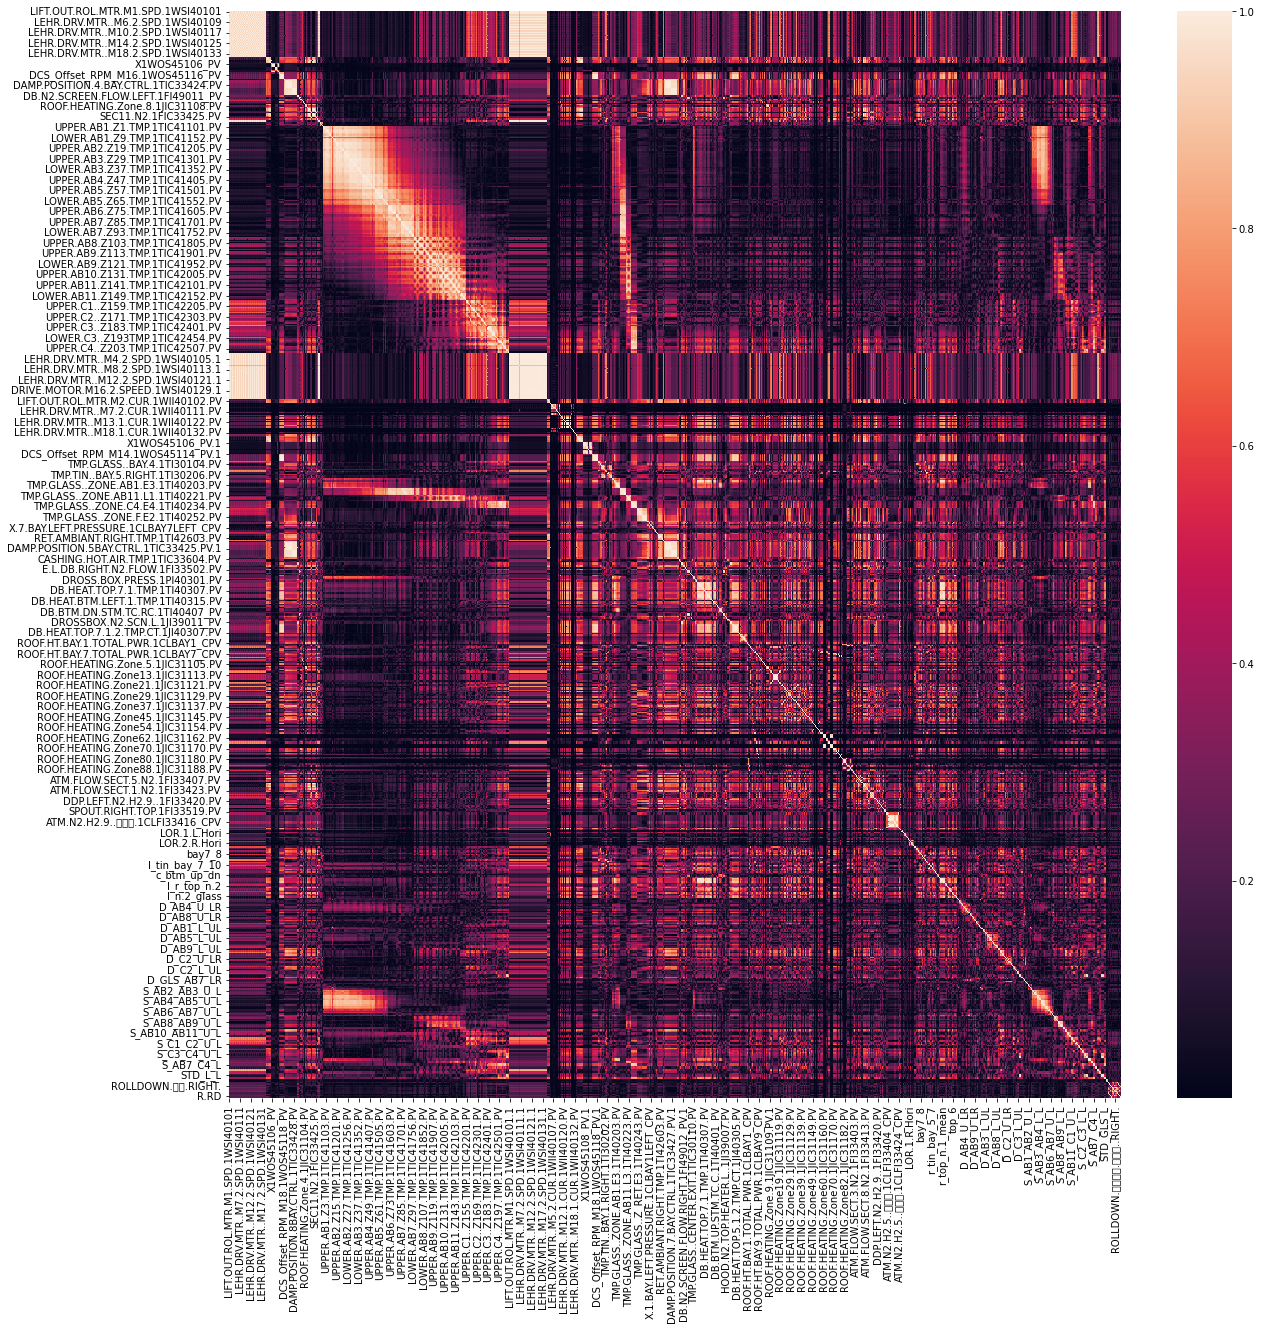

In [ ]:
# 상관계수의 절대값 히트맵 확인
plt.figure(figsize=(20,20))
sns.heatmap(corr_arr)

# 히트맵을 확인해보면, 상관계수가 높은 피처를 쉽게 확인할 수 있음

In [ ]:
# 상관계수가 0.9 이상인 컬럼 중 1개만 남기고 모두 제거
del_list = []
## i : 상관계수 데이터 프레임의 컬럼
for i, col in enumerate(corr_arr.columns):
    ## j : 상관계수 데이터 프레임의 인덱스
    for j in range(len(corr_arr.index)):
        ## i행 피처와 j열 피처가 동일한 피처인 경우, 자기 자신에 대한 상관계수는 당연히 1이므로 삭제하지 않음
        if i == j:
            continue
        ## i행 피처의 상관계수가 이미 삭제 리스트에 있는 경우 넘어감
        elif corr_arr.index[i] in del_list:           
            break
        ## 만약 j행 피처와 i열 피처의 상관계수가 0.9 이상인 경우, j행을 삭제 리스트에 추가함
        ## 코드가 위에서 아래로 순차적으로 실행되기 때문에
        ## i행 피처에 대한 상관계수가 0.9 이상인 경우 위에서 break 처리를 받음
        ## 즉, (i, j) 상관계수가 0.9인 경우 j컬럼만 삭제리스트에 추가되고 i컬럼은 삭제리스트에 추가되지 않음
        # print(i, j, corr_arr.index[j], np.abs(corr_arr.iloc[j,i]))
        if np.abs(corr_arr.iloc[j,i]) >= 0.9:
            del_list.append(corr_arr.index[j])
            # print(corr_arr.index[j], '-->', corr_arr.index[i])
# 확인
len(del_list)

679

In [ ]:
# del_list에 있는 컬럼은 제외
total_col = fact_data.columns.tolist()
col_remain = []
for c in total_col:
    if c not in del_list:
        col_remain.append(c)
len(col_remain)

382

In [ ]:
# 저장
fact_data = fact_data[col_remain]
fact_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8145 entries, 2016-01-01 07 to 2016-12-31 23
Columns: 382 entries, LIFT.OUT.ROL.MTR.M1.SPD.1WSI40101 to ROLLDOWN.진공패드.폐기율..RIGHT.
dtypes: float64(376), int64(6)
memory usage: 23.8+ MB


In [ ]:
# 파일로 저장
fact_data.to_csv("/content/drive/MyDrive/나무플래닛/3. 산출물/fact_data_var_corr", header=True, index=True)

#### 3_1.소스코드의 이해

In [ ]:
# 데이터 만들기
# 컬럼 0,1,2,3,4는 상관계수 1.0으로 종속성이 매우 높음
# 이 경우 컬럼 0만 이용하고 1,2,3,4는 제외하고자 함
arr = np.zeros(10*10).reshape(10,10)
df = pd.DataFrame(arr)
df.iloc[0:5,0:5] = 1.0
df

,0,1,2,3,4,5,6,7,8,9
0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
del_list = []

for i, col in enumerate(df.columns):
    for j in range(len(df.index)):
        # 행과 열이 동일한 경우, 즉 자기 자신에 대한 판단은 제외함
        if i ==j:
            continue
        elif df.index[i] in del_list:
            break
        if df.iloc[j,i] >= 0.9:
            print(i)
            # del_list에 j번째 인덱스만 저장함
            del_list.append(df.index[j])

print(del_list)
# 컬럼 0번과 상관계수가 0.9 이상인 컬럼은 모두 삭제 대상이 됨

0
0
0
0
[1, 2, 3, 4]
